# Random Forest Classifier
Advanced tool for classifying vacuum gauges 

* [Setup](#setup)
    * [Environment](#env)
    * [Data Retrieval (illustrative)](#retrieval)
    * [Data Normalization (illustrative)](#norm)
    * [Data Interpolation (illustrative)](#interpolate)
    * [Data Masking (illustrative)](#masking)
* [Dataset Creation](#create)
    * [Bin Data (illustrative)](#level)
    * [Generate Dataset](#gen)
    * [Select Dataset](#select)
* [Random Forest Classifiaton](#random)
    * [Split Dataset](#split)
    * [Train Model (illustrative)](#train)
    * [Confusion Matrix (illustrative)](#confusion)
    * [Parameter Optimization (illustrative)](#crossvalidate)
    * [Manual Optimization (illustrative)](#manuel)
    * [Final Evaluation](#eva)
* [Use Model](#use)
    * [Save Model](#save)
    * [Load Model](#load)

# <a id='setup'> Setup </a>
## <a id='env'>Environment </a>

In [1]:

%run BackEnd_Plotters.ipynb
%run BackEnd_DataProcessing.ipynb
%run BackEnd_Classifiers.ipynb


Populating the interactive namespace from numpy and matplotlib


## <a id='retrieval'> Retrieve Data </a>

In [ ]:
gauge_id = "VGPB.4.7L5.R.PR"
fillNo = 2219

pressure_readings,\
time_readings,\
beam_time,\
beam_energy = retrieve_gauge_data(gauge_id, fillNo,show_plot=True)


## <a id='norm'> Data Normalization </a>

In [ ]:
pressure_readings,\
beam_energy = normalize_y(time_readings,
                          beam_time,
                          pressure_readings,
                          beam_energy,
                          show_plot=True)

## <a id=interpolate> Data Interpolation </a>

In [ ]:
time_readings,\
pressure_readings,\
beam_time,\
beam_energy = interpolate_readings(pressure_readings, time_readings, beam_time, beam_energy,
                                   show_plot=True)


## <a id='masking'> Data Masking </a>

In [ ]:
mask,\
threshold = double_threshold_energy_masking(time_readings, 
                             beam_time,
                             beam_energy,
                            show_plot=True)

# <a id='create'> Dataset Creation </a>
## <a id='level'> Bin the Data </a>
Split data into segments and return their averages. <br>
These are used as the **feautures** for the Algorithm

In [ ]:
pressure_levels = bin_data(pressure_readings[mask],8)
plot_levelled_data(gauge_id, pressure_levels, time_readings[mask],pressure_readings[mask])

## <a id='gen'> Generate Datasets </a>
Use CSV file catalogue containing probe/gauge information and their ground truth to generate a SciKit Learn dataset ('bunch').


In [7]:

balanced_datasets = get_or_create_datasets("Balanced", feature_spec=(1,13), reset=0, verbose=1)


Catalogue Balanced: (495, 6)


In [ ]:
for key in balanced_datasets.keys(): 
    print("{0}Balanced Dataset with {2} Features:{1}".format(color.BOLD,color.END,key))
    display(balanced_datasets[key].head())

In [8]:

representative_datasets = get_or_create_datasets("Representative", feature_spec=(1,13), reset=0, verbose=1)


Catalogue Representative: (1248, 6)


In [ ]:
for key in representative_datasets.keys(): 
    print("{0}Representative Dataset with {2} Features:{1}".format(color.BOLD,color.END,key))
    display(representative_datasets[key].head())

## <a id="select"> Select Specific Dataset </a>
Used for illustrating how the algorithm is prepared step-by-step, for full optimization <br>
all loaded datasets can be used to vary the no. of features.

In [10]:
feature_options = representative_datasets.keys()
feature_field = widgets.BoundedIntText(
    value=4,
    min=min(feature_options),
    max=max(feature_options),
    step=1,
    description='No Of Features:',
)
display(feature_field)

BoundedIntText(value=4, description='No Of Features:', max=12, min=1)

<IPython.core.display.Javascript object>


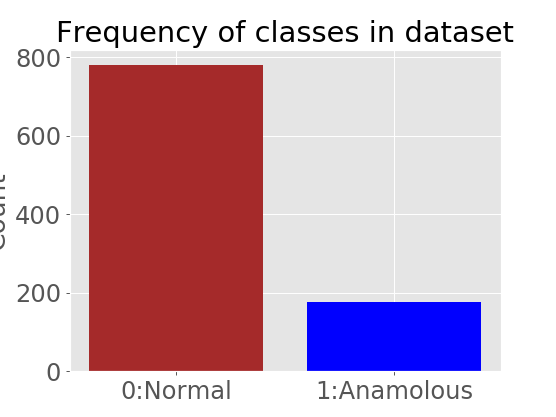

,Bin0,Bin1,Bin2,Bin3,Response,Probe ID,Fill
0,0.419812,0.190751,0.233995,0.241369,1,VGPB.220.1L1.X.PR,5979
1,0.055150,0.050539,0.044476,0.037265,0,VGPB.222.1L1.X.PR,5979
2,0.937469,0.862674,0.766351,0.654398,0,VGPB.190.1L2.X.PR,5979
3,0.814200,0.682644,0.557005,0.493102,0,VGPB.220.1L2.X.PR,5979
4,0.801912,0.663048,0.541328,0.486384,1,VGPB.222.1L2.X.PR,5979


In [11]:
dataset = representative_datasets[feature_field.value]

X,y,lookup = dataset.iloc[:,0:dataset.shape[1]-3],dataset.Response,dataset.iloc[:,-2:]

plt.figure()
plt.bar(x=['0:Normal','1:Anamolous'],height=[y.value_counts()[0],y.value_counts()[1]],color=['brown','blue'])
plt.ylabel("Count")
plt.title("Frequency of classes in dataset")
plt.show()

display(dataset.head())

# <a id='random'> Random Forest Classification </a>
## <a id='split'> Setup Training and Testing sets </a>
Split the data into a test and training set using a random seed. 

In [12]:
X_train, X_test, X_train_labels, X_test_labels = split_dataset(X,y, seed = 0)

# Random Forest
## Unoptimized Model
Complete run through of creation and evaluation of simple Random Forest model.<br>
No attempt made to optimize parameters in this section.

### <a id='train'>Train Model</a>
A random forests is a meta classifier, in the sense that it fits several classifiers and averages them to improve the predictive accuracy of the model. 

Each tree is a decision tree that answers yes-no (logical) style questions. For numeric parameters, this might be whether it is less than a certain value.

To create these trees the original dataset is boostrapped, that is it is randomly sampled (with repetitions!) until the same number of samples exist.
Then a certain number of features are included in the decision trees as parameters to ask yes-no(logical) style questions about.

To build the best decision tree given a random bootstrapped dataset and selection of features, a metric like Gini impurity or entropy (information decay)
is used. In the case of impurity, this is the likelihood that a randomly taken sample is incorrectly labelled. Hence the tree is constructed
to minimize the impurity. When impurity cannot be reduced further by asking more questions, a leaf node is made - which is the 'answer' that a 
decision tree makes given a certain sample.

Complete run through of creation and evaluation of simple Random Forest model.<br>
No attempt made to optimize parameters in this section. <br>
<img src=https://i.imgur.com/l2m9ere.png alt='Illustration of Random Forest' align='left' width=800></img>

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
RF = sklearn.ensemble.RandomForestClassifier(random_state=0).fit(X_train,X_train_labels)
print(RF)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


### Predict classes in unseen data
With our model trained, we can try to use it to predict labels of unseen data.

In [16]:
yhat = RF.predict(X_test)
print(yhat)

[0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0]


We can also see how confident each prediction was by looking at the probability of <br> 
each class for each sample.

In [18]:
yhat_prob = RF.predict_proba(X_test)
print("{0}   1     0{1}\n{2}\n...\n {3}".format(color.BOLD,color.END,yhat_prob[0:5],yhat_prob[-1]))

   1     0
[[0.8 0.2]
 [1.  0. ]
 [0.  1. ]
 [0.8 0.2]
 [1.  0. ]]
...
 [1. 0.]


### <a id='confusion'>Confusion Matrix</a>
A confusion matrix is a useful tool for understanding how our model performs.<br>

<b>Precision:</b> How well our model correctly predicts a label.<br> Indicates how confident we are that positive is indeed positive. <br> Hence Precision = True Positive / (True Positive + False Positive)

<b>Recall:</b> The amount true positive samples over the total amount of positive samples. <br> Indicates that we class is correctly recognized. <br> Hence Recall = True Positive / (True Positive + False Negative)

<IPython.core.display.Javascript object>


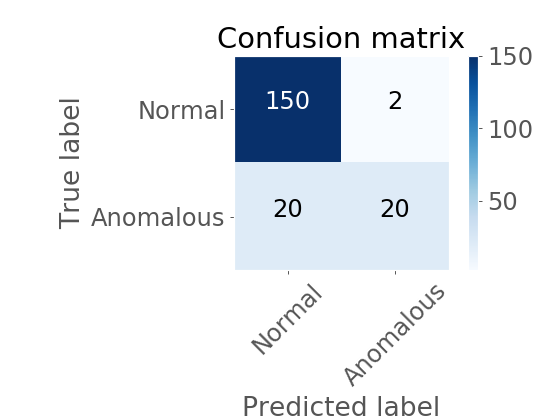

Confusion matrix, without normalization
[[150   2]
 [ 20  20]]


In [19]:

cnf_matrix = get_confusion_matrix(X_test_labels,yhat, normal=False)


### Classification Report
Breakdown the confusion matrix above to get the precision and recall for each class. <br>

<b>F1 Score:</b> Mean of the precision and the recall, a value of 1.0 is a perfect classifier.

In [20]:
print (classification_report(X_test_labels, yhat))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       152
           1       0.91      0.50      0.65        40

    accuracy                           0.89       192
   macro avg       0.90      0.74      0.79       192
weighted avg       0.89      0.89      0.87       192



### Simple Metric Accuracy
To cross-compare with other machine learing algorithms, we also calculate the accuracy. I.e. how often our model <br>
correctly predicts labels in the test set based on their ground truths.

In [21]:
yhat = RF.predict(X_test)
xhat = RF.predict(X_train)
training_std_dev = np.std(xhat==X_train_labels)/np.sqrt(xhat.shape[0]) # std error appropriate?
testing_std_dev = np.std(yhat==X_test_labels)/np.sqrt(yhat.shape[0])
print("%sTrain set Accuracy:%s %.3f \xb1 %.3f" %(color.BOLD, color.END, metrics.accuracy_score(X_train_labels, xhat),training_std_dev))
print("%sTest set Accuracy:%s %.3f \xb1 %.3f\n" %(color.BOLD, color.END, metrics.accuracy_score(X_test_labels, yhat),testing_std_dev))

Train set Accuracy: 0.988 ± 0.004
Test set Accuracy: 0.885 ± 0.023



# <a id='crossvalidate'> Grid Search Cross-Validation </a>
Test our model over a range of different values to find the best value for that parameter. <br>

We implement GridSearch once manually, to reveal what it does, and then use the in-built function provided by SkLearn. <br>

This section corresponds to the left branch of this flowchart, as we are trying to find the best paramaters to build our model with. <br>

<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png" alt="Grid Search Workflow" width="400" align="left"> </img>

## Manual Grid-Search Walkthrough

### Cross-Validation
If we simply split our dataset once and train our model this way, it is possible that the model will be biased by how we happen to split 
up the original data.

To deal with this potential bias in performance, we employ cross-validation.

Here we split the dataset differently over multiple iterations to improve generalization. <br>

For each split with the cross-validator, we put aside 20% of the training data for validation and 80% for traning. <br>
<b>Background Reading: </b><a href="https://scikit-learn.org/stable/modules/cross_validation.html">SciKit Learn Documentation: Cross Validation<a> <br>
    

Here we have chosen to use Stratified K fold splitter, which preserves the original distribution of the dataset (about 50% of each class) in both the training_set and testing_set.<br>
By convention, we run 10 passes to ensure a fair scoring. <br>
<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0071.png" alt="Stratified KFold" width="600" align="left"></img>

In [ ]:
cv_splitter,\
average_cv_score = cross_validate_sets(X_train,
                                       X_train_labels,
                                       scorer = metrics.balanced_accuracy_score,
                                       cv_splitter = sklearn.model_selection.StratifiedShuffleSplit,
                                       classifier=sklearn.ensemble.RandomForestClassifier,
                                       verbose=0)


##  <a id="manual">Find Best Parameter Manually</a>
If cross-validation is used to reduce bias from splitting, it is possible to objectively <br>
find the best parameter for maximizing a certain score (e.g. accuracy or the f1-score)

Here this is used to vary a single parameter and find it's optimum value, in the Grid Search <br>
in the section this is generalized to any number of parameters. 

Note that the seed only fixes the CV_splitter, results may still vary depening on which seed <br>
was used to split the dataset earlier.

In [ ]:
%run BackEnd_Classifiers.ipynb

In [ ]:
best_score, best_param_setting = find_best_parameter_manualy(X_train, X_train_labels,
                                                         scorer = metrics.balanced_accuracy_score, cv_splitter=sklearn.model_selection.StratifiedShuffleSplit,
                                                         classifier = sklearn.ensemble.RandomForestClassifier, seed = 0, verbose=1, show_plot=True)

print("{}Best Score{}: {} for parameter set to {}".format(color.BOLD,color.END,best_score, best_param_setting))

## <a id="optimal">Optimal Parameters for the Model</a>

Employ techiques from optimizing the other classifiers (see associated notebooks) to <br>
identify the best parameters for our model. <br>

In this case we can vary:
* <b>n_estimators</b>: number of trees
* <b>Criterion</b>: used to measure quality of split
* <b>Tree Building</b>:
    * <b> Max depth</b>: Maximum depth of tree, by default expanded until leaf nodes are pure
    * <b> Min Samples Split</b>: Minimum number of samples needed to split an internal node
    * <b> Min Samples Leaf</b>: Minimum number of samples needed at a leaf node
    * <b> Min Weight Fracton Leaf</b>: Minimum weighted fraction of the sum total of weights
    * <b> Max Features</b>: Number of features to consider when looking for the best split
    * <b> Max Leaf Nodes</b>: Grow tree in best-first fashion (based on impurity)
    * <b> Min Impurity Decrease</b>: Split node if this decreases the impurity by this value
* <b>Bootstrap</b>: Whether bootstrap samples are used when building trees

As before we will vary these parameters by iterating over them. For each parameter combination we then <br>
cross-validate the performance to make sure our score (the accuracy) isn't biased by how we happened to <br>
split the training set. <br>

<b> WARNING </b> As this is an exhaustive technique, it will take a long time to execute

### Varying The No. Of Features

Before we binned the data by calculating the average of X intervals. 

Changing the number of intervals could affect how well our model can discriminate between expected and unexpected behaviour, <br> 
since too many may confuse it by giving it meaningless patterns and too few may not give it enough useful information.

To implement this we iterate over different datasets with different number of bins.<br>
For each dataset we use Grid-Search Cross-validation as before to get the best parameters for that dataset.

**WARNING** If results between manual and grid search do NOT match, this is likely due to the seed value being different

In [70]:
best_no_of_features, best_params, best_score = find_best_parameters(balanced_datasets,
                                                                    param_grid = {'C': np.linspace(0.01,2,20),'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
                                                                    classifier = sklearn.ensemble.RandomForestClassifier,
                                                                    cv_splitter = sklearn.model_selection.StratifiedShuffleSplit,
                                                                    scorer=metrics.balanced_accuracy_score,
                                                                    seed = 0,
                                                                    verbose=1)
print("{0}Best Score{1}: {2:.2f} with parameters: \n {3}".format(color.BOLD,color.END,best_score, best_params))

>>>>DOCUMENTATION<<<<

    penalty : str, 'l1', 'l2', 'elasticnet' or 'none', optional (default='l2')
        Used to specify the norm used in the penalization. The 'newton-cg',
        'sag' and 'lbfgs' solvers support only l2 penalties. 'elasticnet' is
        only supported by the 'saga' solver. If 'none' (not supported by the
        liblinear solver), no regularization is applied.

        .. versionadded:: 0.19
           l1 penalty with SAGA solver (allowing 'multinomial' + L1)

    dual : bool, optional (default=False)
        Dual or primal formulation. Dual formulation is only implemented for
        l2 penalty with liblinear solver. Prefer dual=False when
        n_samples > n_features.

    tol : float, optional (default=1e-4)
        Tolerance for stopping criteria.

    C : float, optional (default=1.0)
        Inverse of regularization strength; must be a positive float.
        Like in support vector machines, smaller values specify stronger
        regularization.

   

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    6.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    8.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    7.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    8.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best Score: 0.81 with parameters: 
 {'C': 1.266842105263158, 'solver': 'newton-cg'}


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    7.9s finished


## <a id='eva'>Final Evaluaton </a>
Uses seeded training_set (not cross validated!) for a final evaluation of the model, including the standard deviation.

Train Set accuracy_score : 0.7797979797979798
Test Set accuracy_score : 0.6959247648902821


<IPython.core.display.Javascript object>


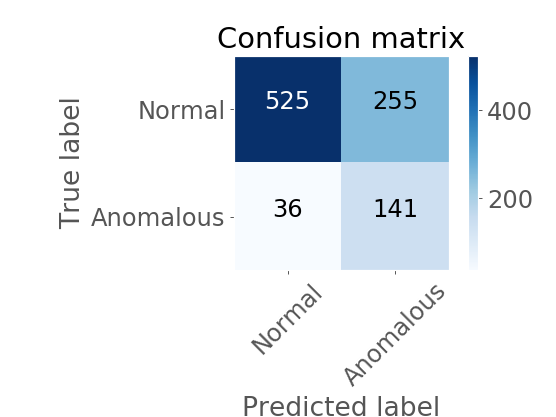

Confusion matrix, without normalization
[[525 255]
 [ 36 141]]
Classification Report
              precision    recall  f1-score   support

           0       0.94      0.67      0.78       780
           1       0.36      0.80      0.49       177

    accuracy                           0.70       957
   macro avg       0.65      0.73      0.64       957
weighted avg       0.83      0.70      0.73       957



In [72]:
testing_dataset = representative_datasets[best_no_of_features-min(representative_datasets.keys())]

model = model_evaluation(balanced_datasets, testing_dataset = testing_dataset, classifier = sklearn.ensemble.RandomForestClassifier,
                                no_of_features = best_no_of_features, best_params = best_params,
                                scorer = metrics.accuracy_score, seed = 0, verbose = 0)

# <a id='use'>Use Model</a>
## <a id='save'>Store Model</a>

In [ ]:
save_model(model, best_no_of_features)

## <a id='load'>Load Model</a>

In [ ]:
model = load_model()